In [2]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [3]:
class World:
    def __init__(self, debug=False):
        self.objects = [] 
        self.debug = debug
        
    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-10,10)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-10,10)                              # Y軸も同様に
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に
        
        elems = []
        
        if self.debug:        
            for i in range(1000): self.one_step(i, elems, ax) 
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=100, interval=1000, repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):    ### fig:one_step_add_one_step 
        while elems: elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t = "+str(i), fontsize=10)) 
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(1.0)     # 追加

In [12]:

class IdealRobot:                         ### fig:rewrite_init_for_agent 
    def __init__(self, pose, agent=None, color="k"):  # agentという引数を追加
        self.pose = pose 
        self.r = 0.2 
        self.color = color 
        self.agent = agent   # 追加
        self.poses = [pose]         # 軌跡の描画用。追加
        self.time = 0
        self.odom = pose
    
    def draw(self, ax, elems):  ###idealrobot6draw
        x, y, theta = self.pose                   # 姿勢の変数を分解して3つの変数へ
        xn = x + self.r * math.cos(theta)         #  ロボットの鼻先のx座標 
        yn = y + self.r * math.sin(theta)         #  ロボットの鼻先のy座標 
        elems += ax.plot([x,xn], [y,yn], color=self.color) # ロボットの向きを示す線分の描画
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))   # 上のpatches.Circleでロボットの胴体を示す円を作ってサブプロットへ登録
        
        self.poses.append(self.pose) #以下追加。軌跡の描画
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
            
    @classmethod
    def state_transition(cls, nu, omega, time, pose):    ### fig:state_transition(20-35行目)
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):            ### fig:robot_one_step
        if not self.agent: return
        nu, omega = self.agent.decision(odom = self.odom)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.odom = self.state_transition(nu, omega, time_interval, self.odom)
        #print(self.odom)
        self.time = self.time + time_interval

In [34]:

class Agent:                        ### fig:Agent
    def __init__(self, nu, omega,traj = None):
        self.nu = nu
        self.omega = omega
        self.traj = traj
    def decision(self, observation=None, odom = [0,0,0]):
        
        if self.traj:
            return traj.vector(odom)

            
        else:return 0,0 

class Traj:
    def __init__(self, a,b,end_x=None):#y = ax + b
        self.a = a
        self.b = b
        self.end_x = end_x
        
    def y(self,x):
        return self.a*x + self.b
    
    def theta(self):#傾き
        return math.atan(self.a)
    # -y + ax + b = 0
    def bias(self,x,y):#点との距離
        if self.y(x) >= y:hugo = 1
        else:hugo = -1
        return hugo * abs((self.a*x-y+self.b)/math.sqrt(1+pow(self.a,2)))
    
    def vector(self,odom):#速度の出力
        omega = -(odom[2]-self.theta())*0.2 \
                + self.bias(odom[0],odom[1])*0.2
        if omega >= 20/180*math.pi:omega = 20/180*math.pi
        if omega <= -20/180*math.pi:omega = -20/180*math.pi
        nu = 0.2 - 0.2*omega/(20/180*math.pi)
        
        if self.end_x:
            if odom[0] >= self.end_x:
                nu,omega = 0,0
        return nu,omega
        
        
#a = Traj(0, 2)
#print(a.bias(0,4))

<IPython.core.display.Javascript object>


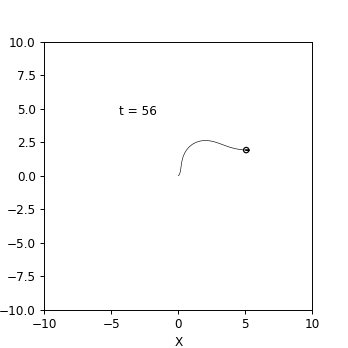

In [37]:
world = World(debug = False)           ### fig:rewrite_robot_for_agent    
traj = Traj(0,2,5)
robot1 = IdealRobot( np.array([ 0, 0, 0]).T,Agent(0,0,traj = traj))  
world.append(robot1)

world.draw()
#print(robot1.pose)